# Simple inversion
Here we will walkthrough a very simple gravity inversion using synthetic data. The goal of the inversion is to recover the geometry of a layer. In this case, the layer is simply the surface of the Earth, which is represented by the density contrast between air and rock.

## Import packages
We need to import the *Invert4Geom* package, as well as a few others.

In [1]:
# set EPSG for plotting functions
import os

import numpy as np
import polartoolkit as ptk
import verde as vd

import invert4geom

os.environ["POLARTOOLKIT_EPSG"] = "3857"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography grid, which represents the *true* Earth topography which we hope to recover during the inversion. The observed gravity will be the forward-calculated gravity effect of this topography.

Below we specify the `spacing` and `region` of the topography, choose a `zref` and `density contrast` to use to calculate the topography's gravity effect, and contaminate the gravity with some pseudo-random noise.

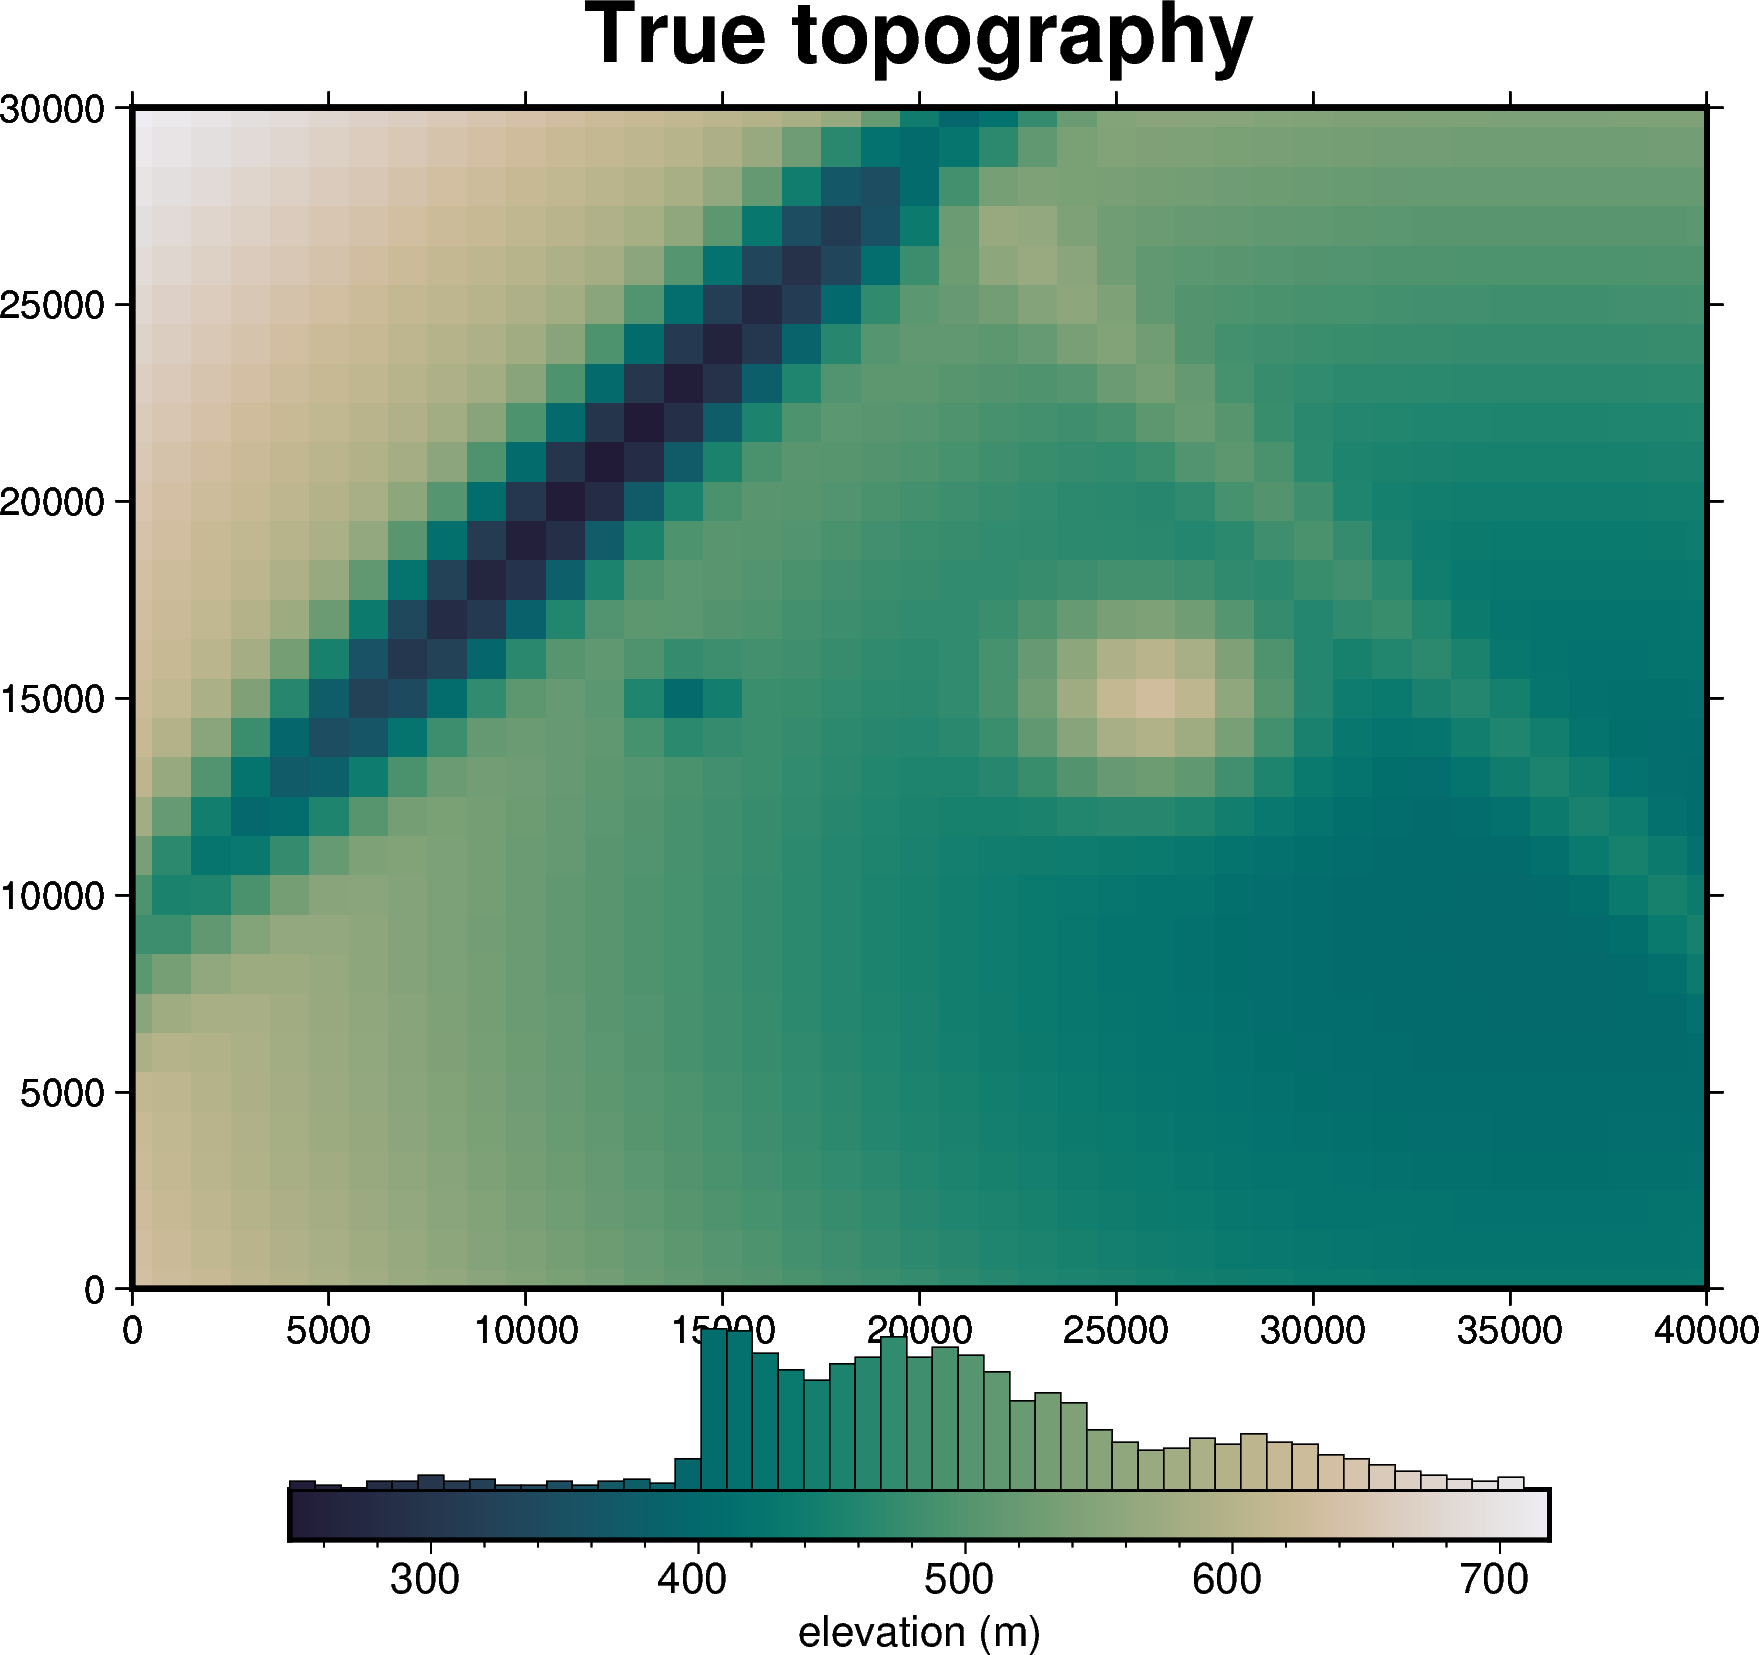

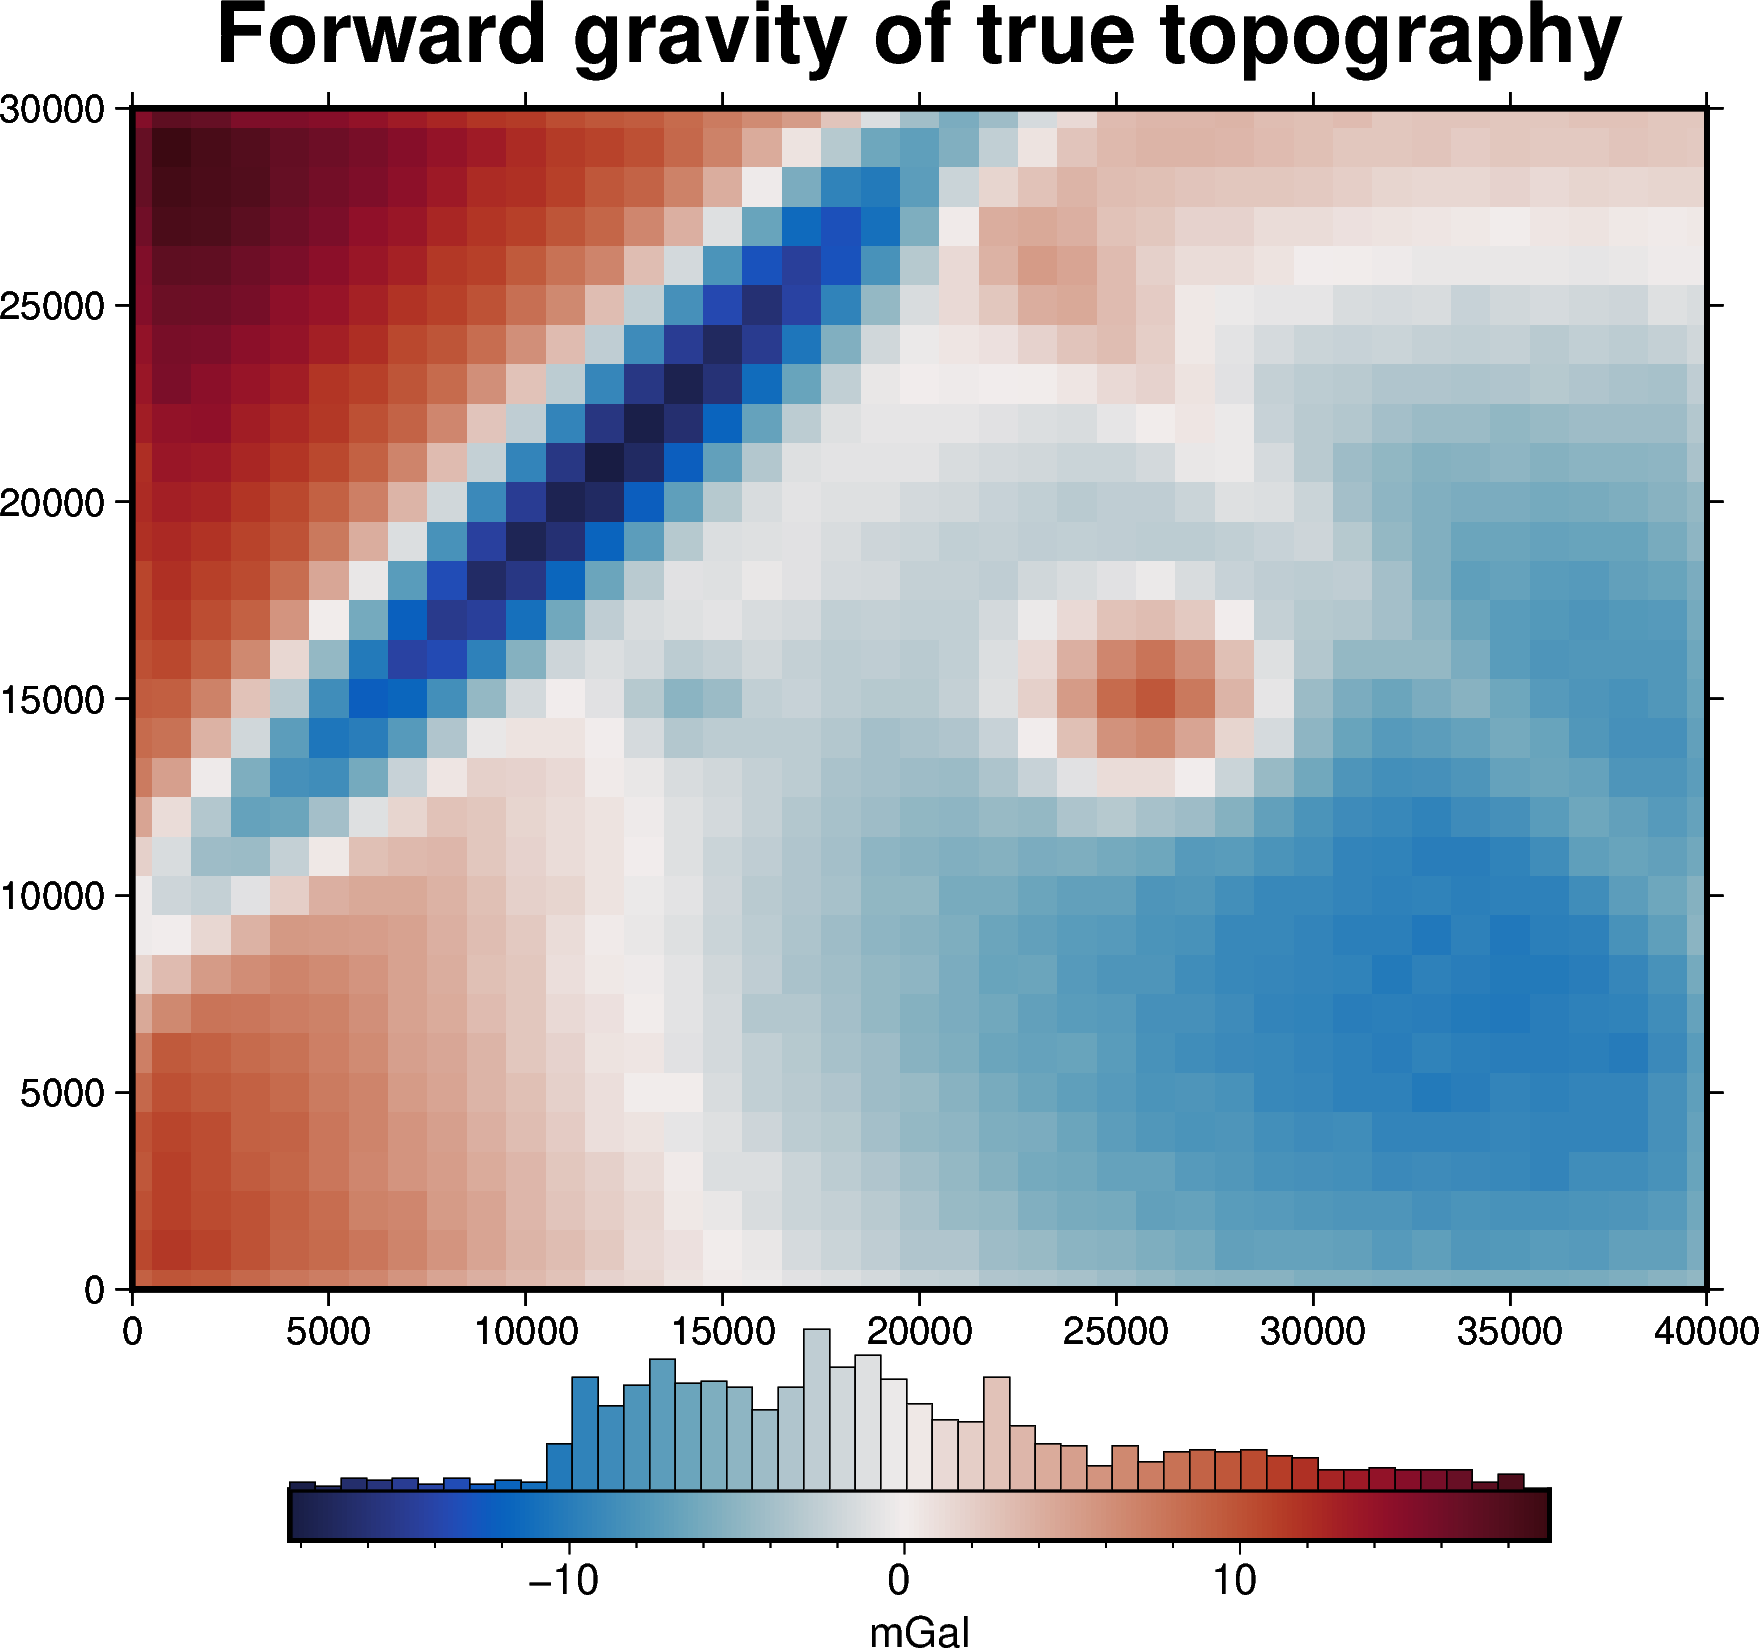

In [2]:
true_topography, _, _, observed_gravity = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    density_contrast=2670 - 1,  # density contrast between rock and air
    zref=500,
    gravity_noise=0.2,
    plot_gravity=True,
    plot_topography=True,
)

In [3]:
observed_gravity

<xarray.Dataset> Size: 21kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473

## Initialize the gravity data

The observed gravity data needs to be in a gridded format, as an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with a variable `gravity_anomaly` with the obersed graviy in mGals, a variable `upward` with the observation elevations in meters, and for prism models, projected coordinates named `easting` and `northing` or for tesseroid models, geographic coordinates named `longitude` and `latitude`. 

With this, we can use the [create_data](../api/generated/invert4geom.create_data.rst) function to add some attributes to the dataset such as:
- `region`: the regional extent of the gravity data (x_min, x_max, y_min, y_max)  
- `spacing`: the spacing of the gridded gravity data  
- `buffer_width`: the width in meters to zoom-in on the data to define and `inner_region`
- `inner_region`: an interior region used for plotting, and statistics to minimize edge effects  
- `model_type`: indicated whether this inversion will use a prism or tesseroid model

In [4]:
data = invert4geom.create_data(observed_gravity)
data

<xarray.Dataset> Size: 21kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

*Invert4Geom* has an xarray dataset accessor [inv](../api/generated/invert4geom.DatasetAccessorInvert4Geom.rst), which adds some properties to an xarray dataset:
- [df](../api/generated/invert4geom.DatasetAccessorInvert4Geom.df.rst): a pandas dataframe representation of the dataset, with NaN values excluded
- [inner_df](../api/generated/invert4geom.DatasetAccessorInvert4Geom.inner_df.rst): same as above, but just for the inner region
-  [inner](../api/generated/invert4geom.DatasetAccessorInvert4Geom.inner_df.rst): a dataset of just the inner region
  
It also allows access to some methods:
-  [forward_gravity](../api/generated/invert4geom.DatasetAccessorInvert4Geom.forward_gravity.rst): compute the forward gravity effect of a supplied model at the observation points of the dataset
-  [regional_separation](../api/generated/invert4geom.DatasetAccessorInvert4Geom.regional_separation.rst): compute the gravity misfit and from it estimate the regional component of the misfit with a variety of techniques
-  [plot_observed](../api/generated/invert4geom.DatasetAccessorInvert4Geom.plot_observed.rst): plot the observed gravity data
-  [plot_anomalies](../api/generated/invert4geom.DatasetAccessorInvert4Geom.plot_anomalies.rst): plot the observed, forward, misfit, regional and residual gravity anomalies

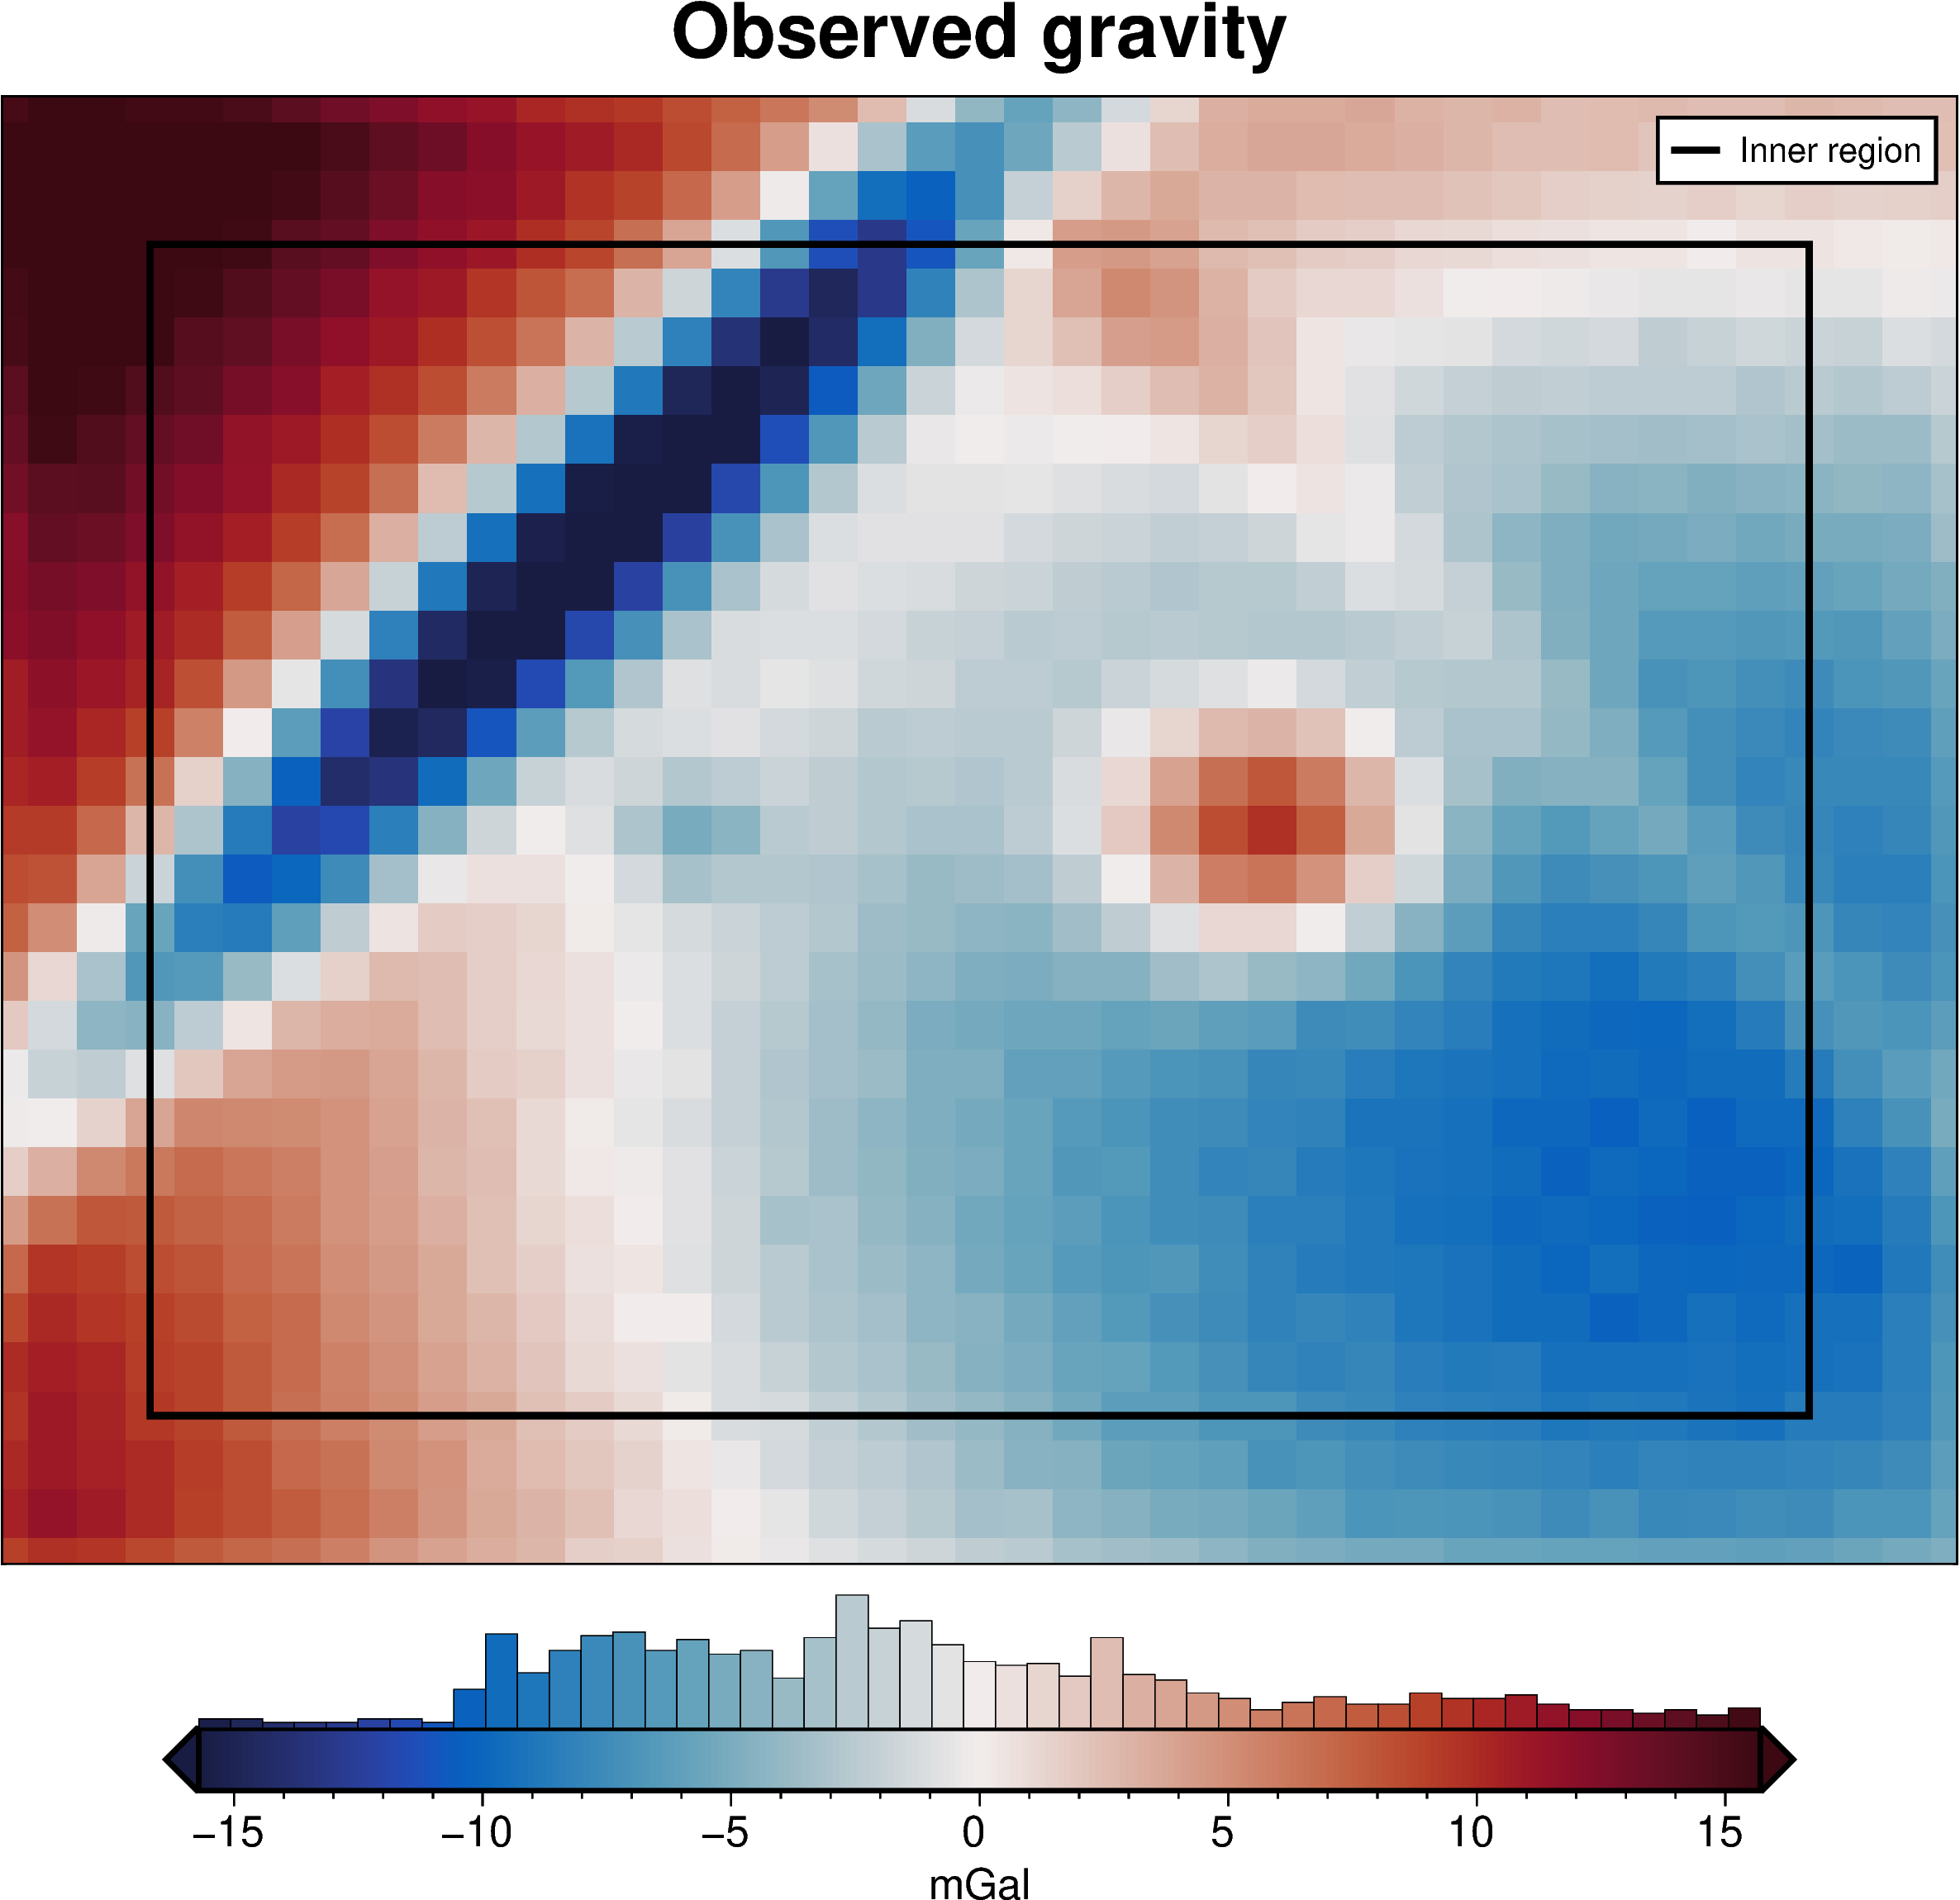

In [5]:
data.inv.plot_observed()

## Create a starting topography grid
Here we assume we know nothing about the topography, so we create a flat grid with a value of 500 m. Instead, you can use an existing topography model, as long as it's an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with a variable `upward` with the height in meters and for prism models, projected coordinates named `easting` and `northing` or for tesseroid models, geographic coordinates named `longitude` and `latitude`. 

In [6]:
# make a flat grid at 500 m
grid_coords = vd.grid_coordinates(
    spacing=1000,
    region=(0, 40000, 0, 30000),
)
starting_topography = vd.make_xarray_grid(
    grid_coords,
    data=np.ones_like(grid_coords[0]) * 500,
    data_names="upward",
)
starting_topography

<xarray.Dataset> Size: 11kB
Dimensions:   (northing: 31, easting: 41)
Coordinates:
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
Data variables:
    upward    (northing, easting) float64 10kB 500.0 500.0 500.0 ... 500.0 500.0

## Create a Model object
Next, we can use the [create_model](../api/generated/invert4geom.create_model.rst) function to take the starting topography grid and convert it into a layer of vertical adjacent prisms or tesseroids. These prisms or tesseroids are assigned densities based on the provided density contrast and reference level. See [the previous notebook](01_discretization.ipynb) for how this works. The dataset output from [create_model](../api/generated/invert4geom.create_model.rst) will hold the prism/tesseroid layer, the `starting_topography`, the current `topography` (which is updated during the inversion) and optional variables `mask`, `upper_confining_layer`, and `lower_confining_layer`, as well as some attributes:
- `region`: the regional extent of the model (x_min, x_max, y_min, y_max)  
- `inner_region`: an interior region defined by the extent of non-nan values in the `mask` variable
   `spacing`: the horizontal size in meters of each prism/tesseroid 
- `model_type`: indicated whether this model consists of prisms or tesseroids 
- `zref`: the reference level used to create the model  
- `density_contrast`: the density contrast (constant value or grid of values) used to create the model

In [7]:
# initialize the Model object
model = invert4geom.create_model(
    zref=500,
    density_contrast=2670 - 1,
    topography=starting_topography,
)
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
    top                    (northing, easting) float64 10kB 500.0 ... 500.0
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
Data variables:
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 500.0 ... 500.0
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0
    buffer_width:      0
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    dataset_type:      model
    model_type:        prisms

The same *Invert4Geom* xarray dataset accessor [inv](../api/generated/invert4geom.DatasetAccessorInvert4Geom.rst) as described above for the gravity dataset also works for the model dataset giving the follow properties:
- [df](../api/generated/invert4geom.DatasetAccessorInvert4Geom.df.rst): a pandas dataframe representation of the dataset, with mask NaN values excluded
- [inner_df](../api/generated/invert4geom.DatasetAccessorInvert4Geom.inner_df.rst): same as above, but just for the inner region
-  [inner](../api/generated/invert4geom.DatasetAccessorInvert4Geom.inner_df.rst): a dataset of just the inner region
-  [masked](../api/generated/invert4geom.DatasetAccessorInvert4Geom.masked.rst): a dataset of just the non-nan region defined by the `mask` variable
-  [masked_df](../api/generated/invert4geom.DatasetAccessorInvert4Geom.masked_df.rst): a pandas dataframe representation of the masked dataset
  
It also allows access to some methods:
-  [plot_model](../api/generated/invert4geom.DatasetAccessorInvert4Geom.plot_model.rst): plot the model in 3D using [PyVista](https://docs.pyvista.org/index.html).

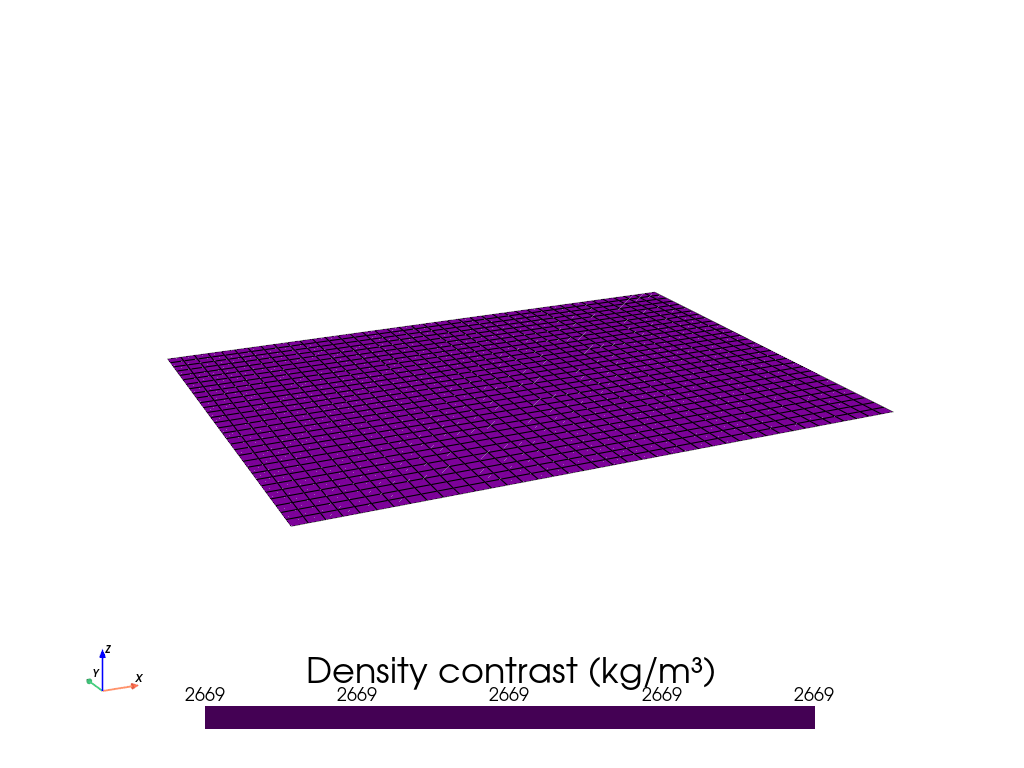

In [8]:
model.inv.plot_model(show_edges=True)

## Gravity misfit
Now we need to use this starting prism model to calculate the gravity misfit, which is the difference between the observed gravity and the gravity effect of this starting prism model. If this case, the starting model is flat, so it has no gravity effect.

To calculate the forward gravity effect of the starting model, use the [inv dataset accessor](../api/generated/invert4geom.DatasetAccessorInvert4Geom.rst) function [forward_gravity](../api/generated/invert4geom.DatasetAccessorInvert4Geom.forward_gravity.rst).


In [9]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)
data

  0%|          | 0/1271 [00:00<?, ?it/s]

<xarray.Dataset> Size: 31kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    forward_gravity  (northing, easting) float64 10kB -0.0 -0.0 ... -0.0 -0.0
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

In many cases, we want to remove a regional signal from the misfit to isolate the residual signal. In this simple case, we assume there is no regional component to the misfit and set it to 0. The [inv dataset accessor](../api/generated/invert4geom.DatasetAccessorInvert4Geom.rst) function [regional_separation](../api/generated/invert4geom.DatasetAccessorInvert4Geom.regional_separation.rst) will subtract the column `forward_gravity` from `gravity_anomaly` to create `misfit`. The `reg` column (chosen here to be 0) is then subtracted from `misfit` to get `res`, the residual gravity misfit.

In [10]:
data.inv.regional_separation(
    method="constant",
    constant=0,
)
data

<xarray.Dataset> Size: 102kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
Data variables:
    upward                    (northing, easting) float64 10kB 1e+03 ... 1e+03
    gravity_anomaly           (northing, easting) float64 10kB 9.07 ... 2.473
    forward_gravity           (northing, easting) float64 10kB -0.0 ... -0.0
    misfit                    (northing, easting) float64 10kB 9.07 ... 2.473
    reg                       (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 10kB 9.07 ... 2.473
    starting_forward_gravity  (northing, easting) float64 10kB -0.0 ... -0.0
    starting_misfit           (northing, easting) float64 10kB 9.07 ... 2.473
    starting_reg              (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    starting_res              (northing, easting) float64 10kB 9.07 ... 2.473
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

We can plot all these anomalies with the accessor function [plot_anomalies](../api/generated/invert4geom.DatasetAccessorInvert4Geom.plot_anomalies.rst).

makecpt [ERROR]: Option T: min >= max


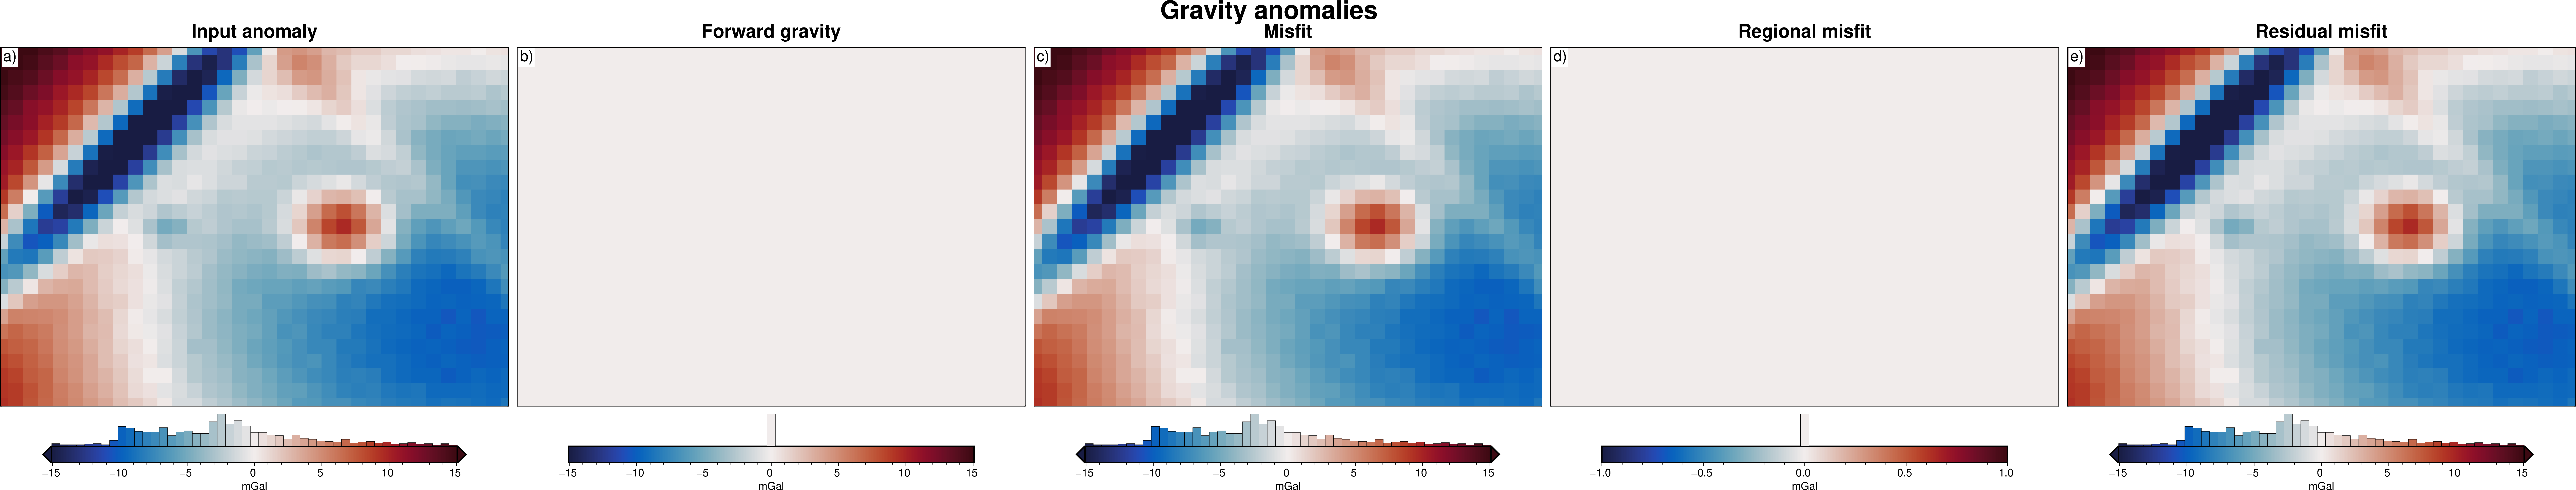

In [11]:
data.inv.plot_anomalies()

## Initialize the Inversion class
The class [Inversion](../api/generated/invert4geom.Inversion.rst) holds the gravity dataset as an instance attribute `data` and the model dataset as an instance attribute `model`, as well as all the parameters of the inversion, such as the stopping criteria, and options for regularization, and how to run the inversion. Some of the options you can set during initialization include:
* `max_iterations`: set to avoid very long running inversions, this should be set high to avoid early termination. 
* `l2_norm_tolerance`: defines when the inversion should end based on the l2-norm of the residual gravity misfit. The l2-norm is the square-root of the root mean squared misfit. 
* `delta_l2_norm_tolerance`: defines when the inversion should end if it is not making any significant progress. A value of 1 means the l2-norm has not changed from the past iteration, while a value of 1.005 means the l2-norm has decreased by ~0.5%.
* `solver_damping`: typically between ~0 and ~1 where high values gives smoother topography.
* `apply_weighting_grid`: a flag to use the optional `weighting_grid` to ensure adhere to constraints`.
  

During the inversion, instance attributes will be added such as the current iteration, the L2-norm and the computation time. The attributes `data` and `model` will be updated during the inversion to track the gravity and topography during each iteration.

In [13]:
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

## Perform inversion
Now that we have the Inversion object which holds the starting model and residual gravity misfit data we can start the inversion. As the inversion progresses, the attributes `inv.data` and `inv.model` will be updated.

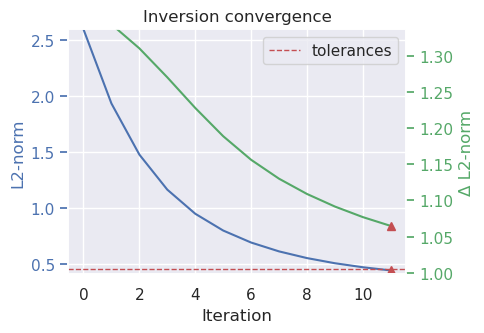

In [14]:
inv.invert(
    plot_dynamic_convergence=True,
)

The above plot shows how the l2-norm and delta l2-norm have been reduced during the inversion. The red line at the bottom marks the set tolerances for each of these. This show that the inversion terminated at the 12 inversion since the l2-norm was lower than the set l2-norm tolerance. 

We can access the statistics of the inversion results with the attribute `stats_df`.

In [15]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,6.743327,2.596792,inf,NaN
1,1.0,3.737865,1.933356,1.343153,1.405626
2,2.0,2.178281,1.475900,1.309950,0.325498
3,3.0,1.350640,1.162170,1.269952,0.326796
4,4.0,0.896104,0.946628,1.227695,0.321989
5,5.0,0.634186,0.796358,1.188697,0.342447
6,6.0,0.474482,0.688827,1.156108,0.361751
7,7.0,0.371599,0.609589,1.129985,0.357378
8,8.0,0.302185,0.549713,1.108922,0.375704
9,9.0,0.253624,0.503611,1.091543,0.364811


We can see why the inversion terminated with `termination_reason`

In [16]:
inv.termination_reason

['l2-norm tolerance']

We can see the gravity data for each iteration:

In [17]:
inv.data

<xarray.Dataset> Size: 214kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
Data variables: (12/21)
    upward                    (northing, easting) float64 10kB 1e+03 ... 1e+03
    gravity_anomaly           (northing, easting) float64 10kB 9.07 ... 2.473
    forward_gravity           (northing, easting) float64 10kB 8.229 ... 2.094
    misfit                    (northing, easting) float64 10kB 9.07 ... 2.473
    reg                       (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 10kB 0.841 ... 0.379
    ...                        ...
    iter_6_initial_residual   (northing, easting) float64 10kB 2.435 ... 0.8778
    iter_7_initial_residual   (northing, easting) float64 10kB 1.982 ... 0.7426
    iter_8_initial_residual   (northing, easting) float64 10kB 1.635 ... 0.6361
    iter_9_initial_residual   (northing, easting) float64 10kB 1.365 ... 0.551
    iter_10_initial_residual  (northing, easting) float64 10kB 1.152 ... 0.4822
    iter_11_initial_residual  (northing, easting) float64 10kB 0.9804 ... 0.4258
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

We can see the topography results for each iteration:

In [18]:
inv.model

<xarray.Dataset> Size: 661kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
    top                    (northing, easting) float64 10kB 620.7 ... 535.2
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
Data variables: (12/63)
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 620.7 ... 535.2
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    ...                     ...
    topography_correction  (northing, easting) float64 10kB 2.436 ... 0.9424
    iter_11_top            (northing, easting) float64 10kB 620.7 ... 535.2
    iter_11_bottom         (northing, easting) float64 10kB 500.0 ... 500.0
    iter_11_density        (northing, easting) int64 10kB 2669 2669 ... 2669
    iter_11_layer          (northing, easting) float64 10kB 620.7 ... 535.2
    iter_11_correction     (northing, easting) float64 10kB 2.436 ... 0.9424
Attributes:
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0
    buffer_width:      0
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    dataset_type:      model
    model_type:        prisms

The final inverted topography can be accessed from the `topography` variable of the prism layer.

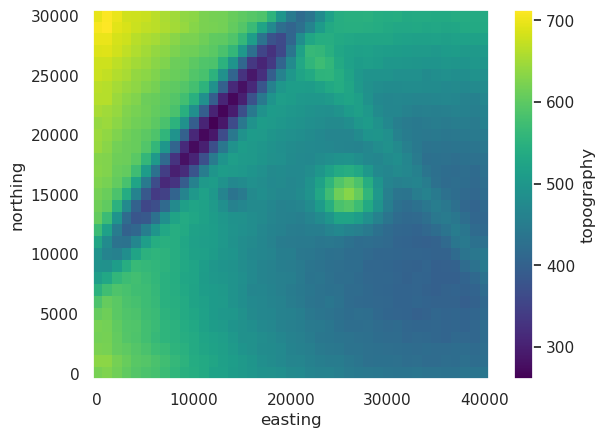

In [19]:
inv.model.topography.plot()

The below three plots show:
1) a comparison of the starting topography (flat) and the final inverted topography
2) a comparison of the residual gravity misfit before and after the inversion
3) the results of 4 of the 12 iterations where the left column shows that iterations starting residual misfit, the middle column shows the current state of the topography, and the right column shows the correction that was applied to the topography during that iteration

In [20]:
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
    top                    (northing, easting) float64 10kB 500.0 ... 500.0
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
Data variables:
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 500.0 ... 500.0
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0
    buffer_width:      0
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    dataset_type:      model
    model_type:        prisms

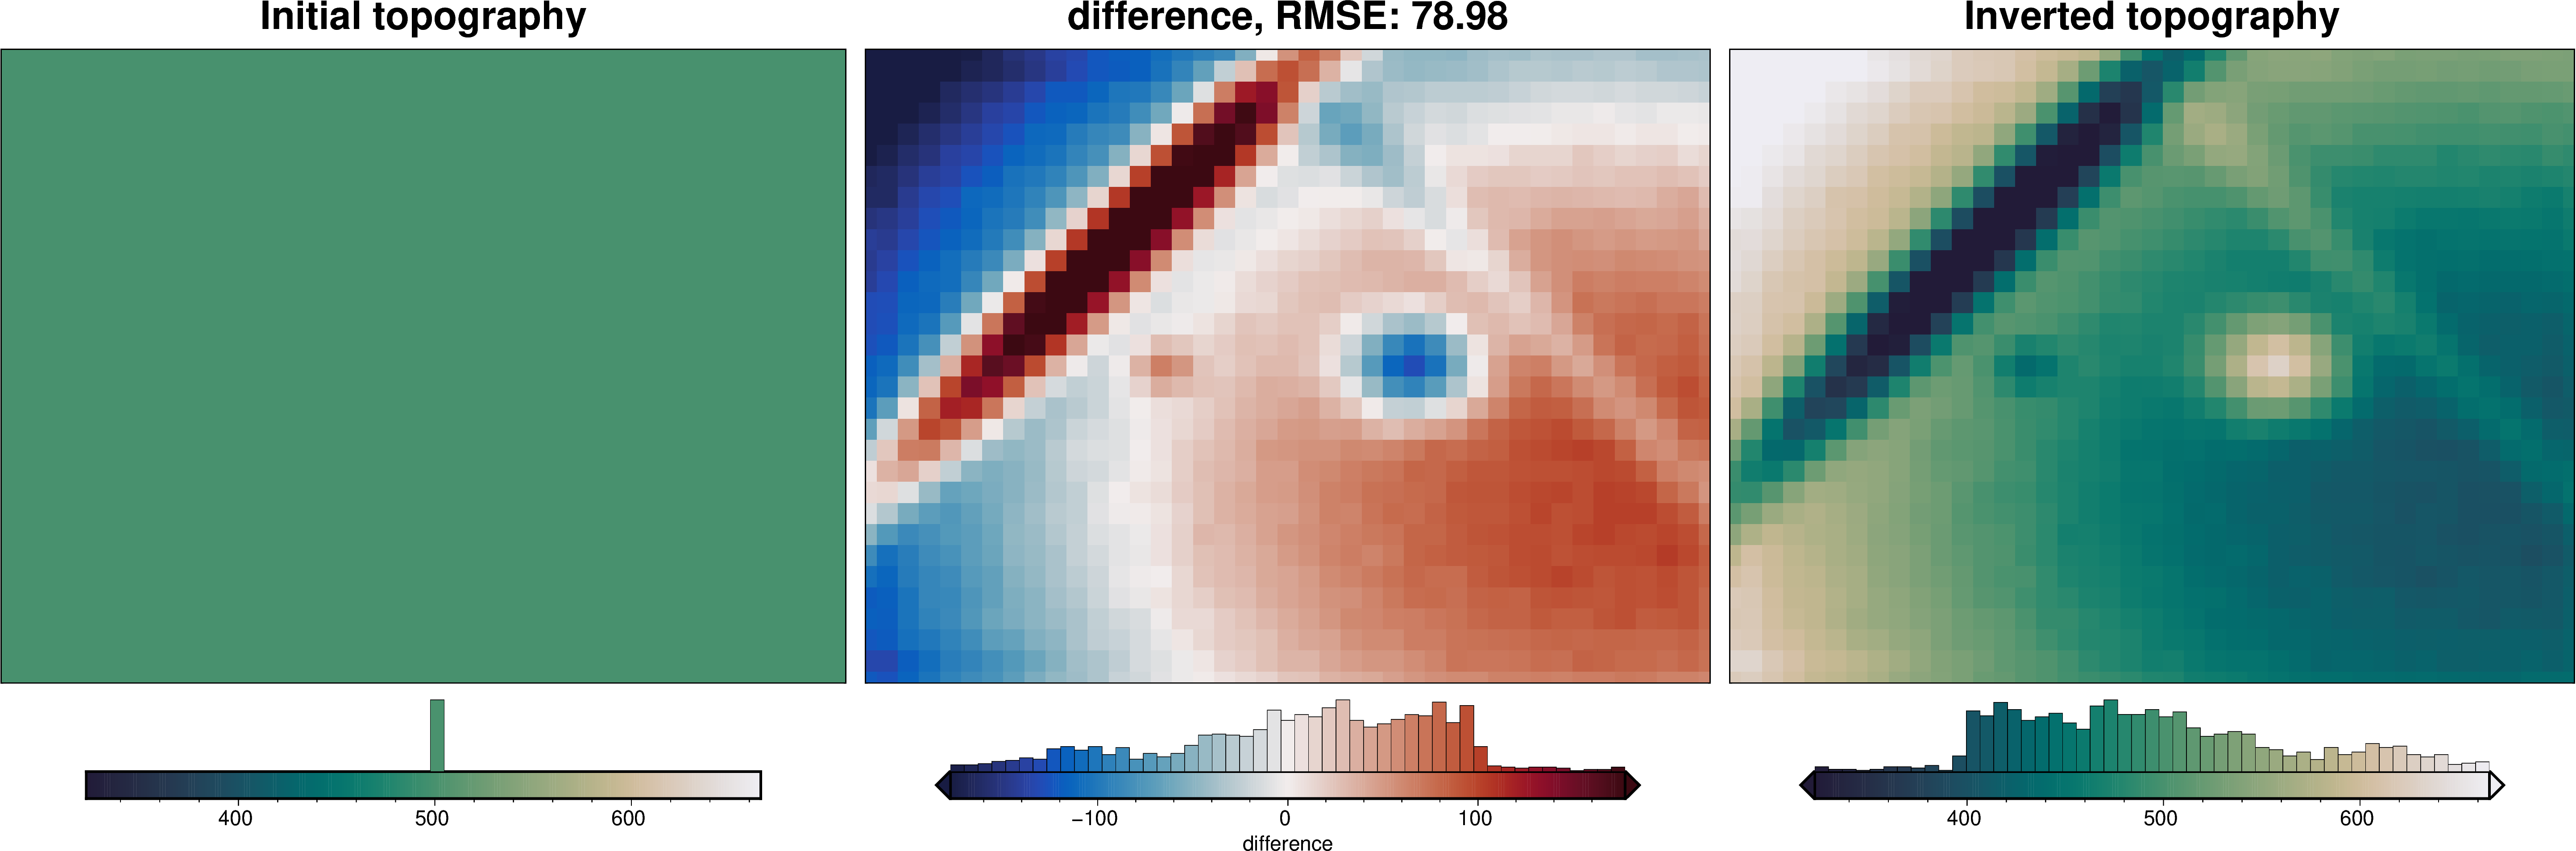

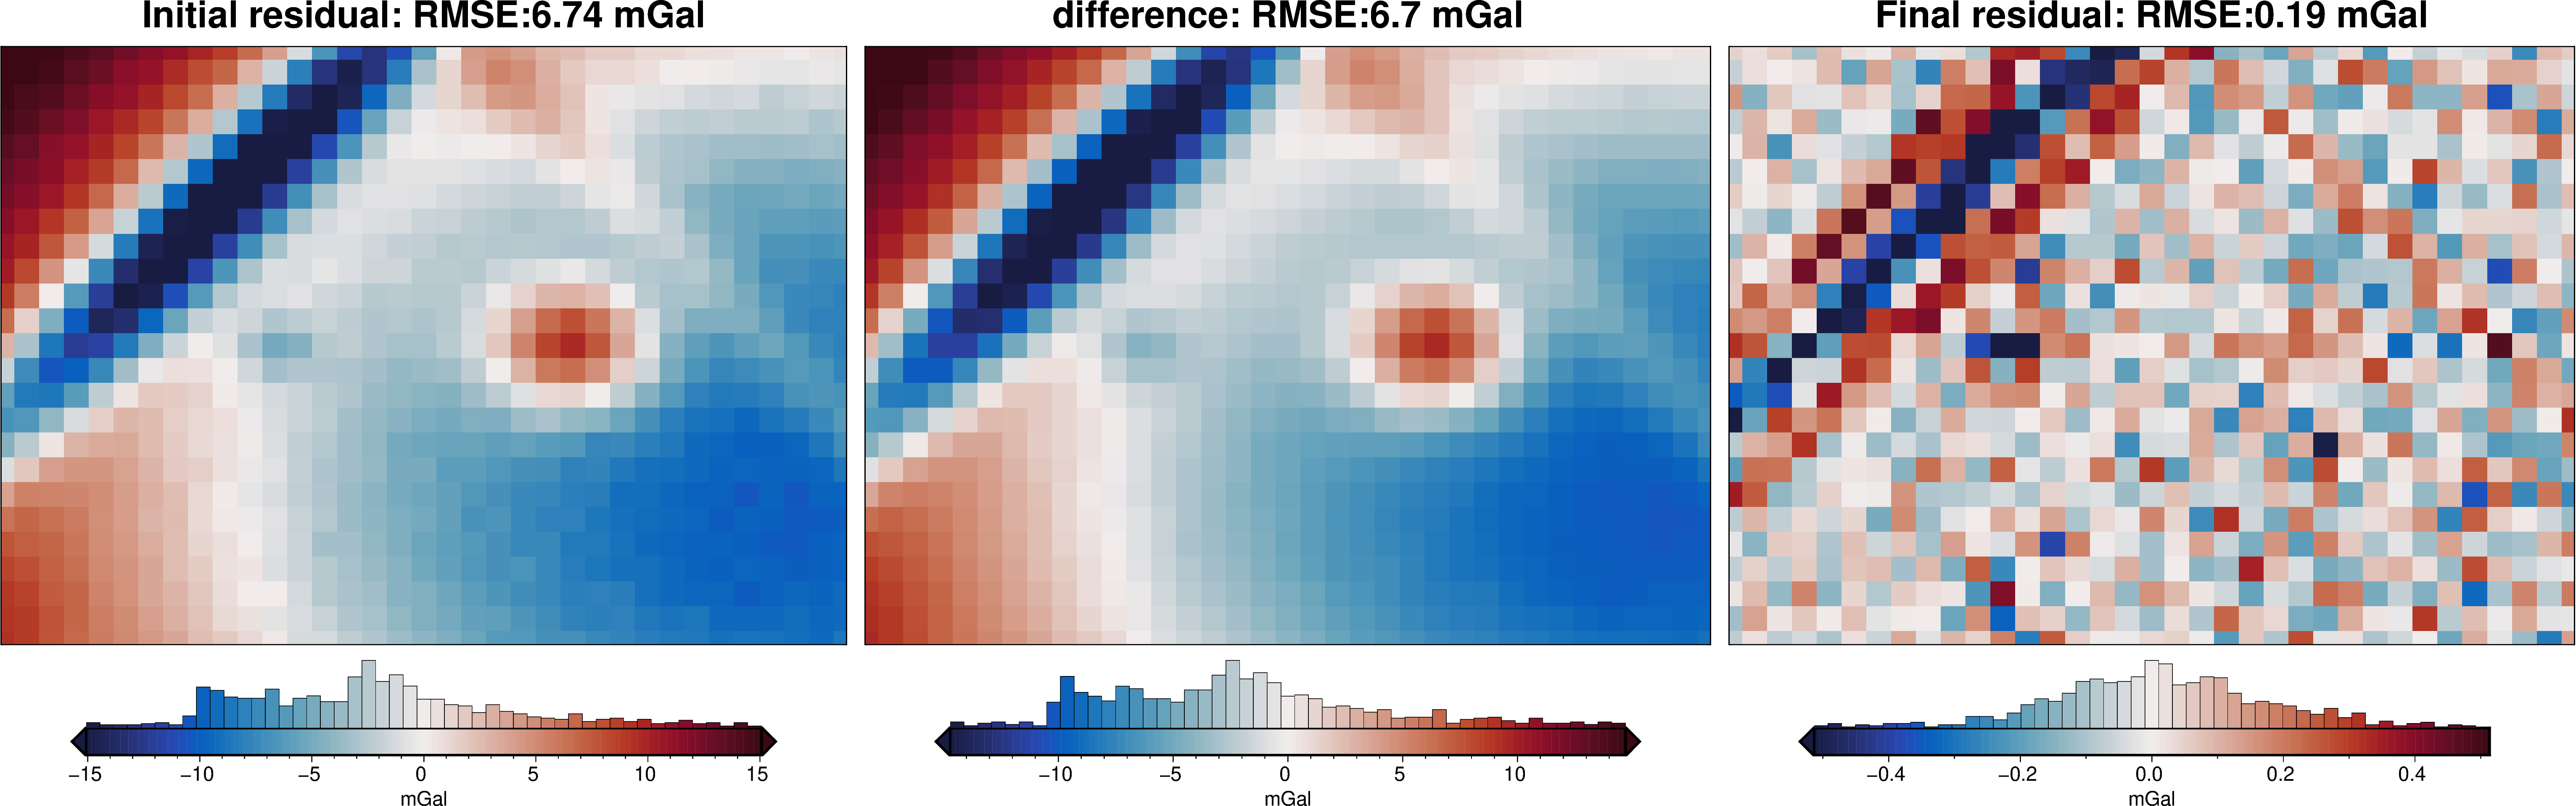

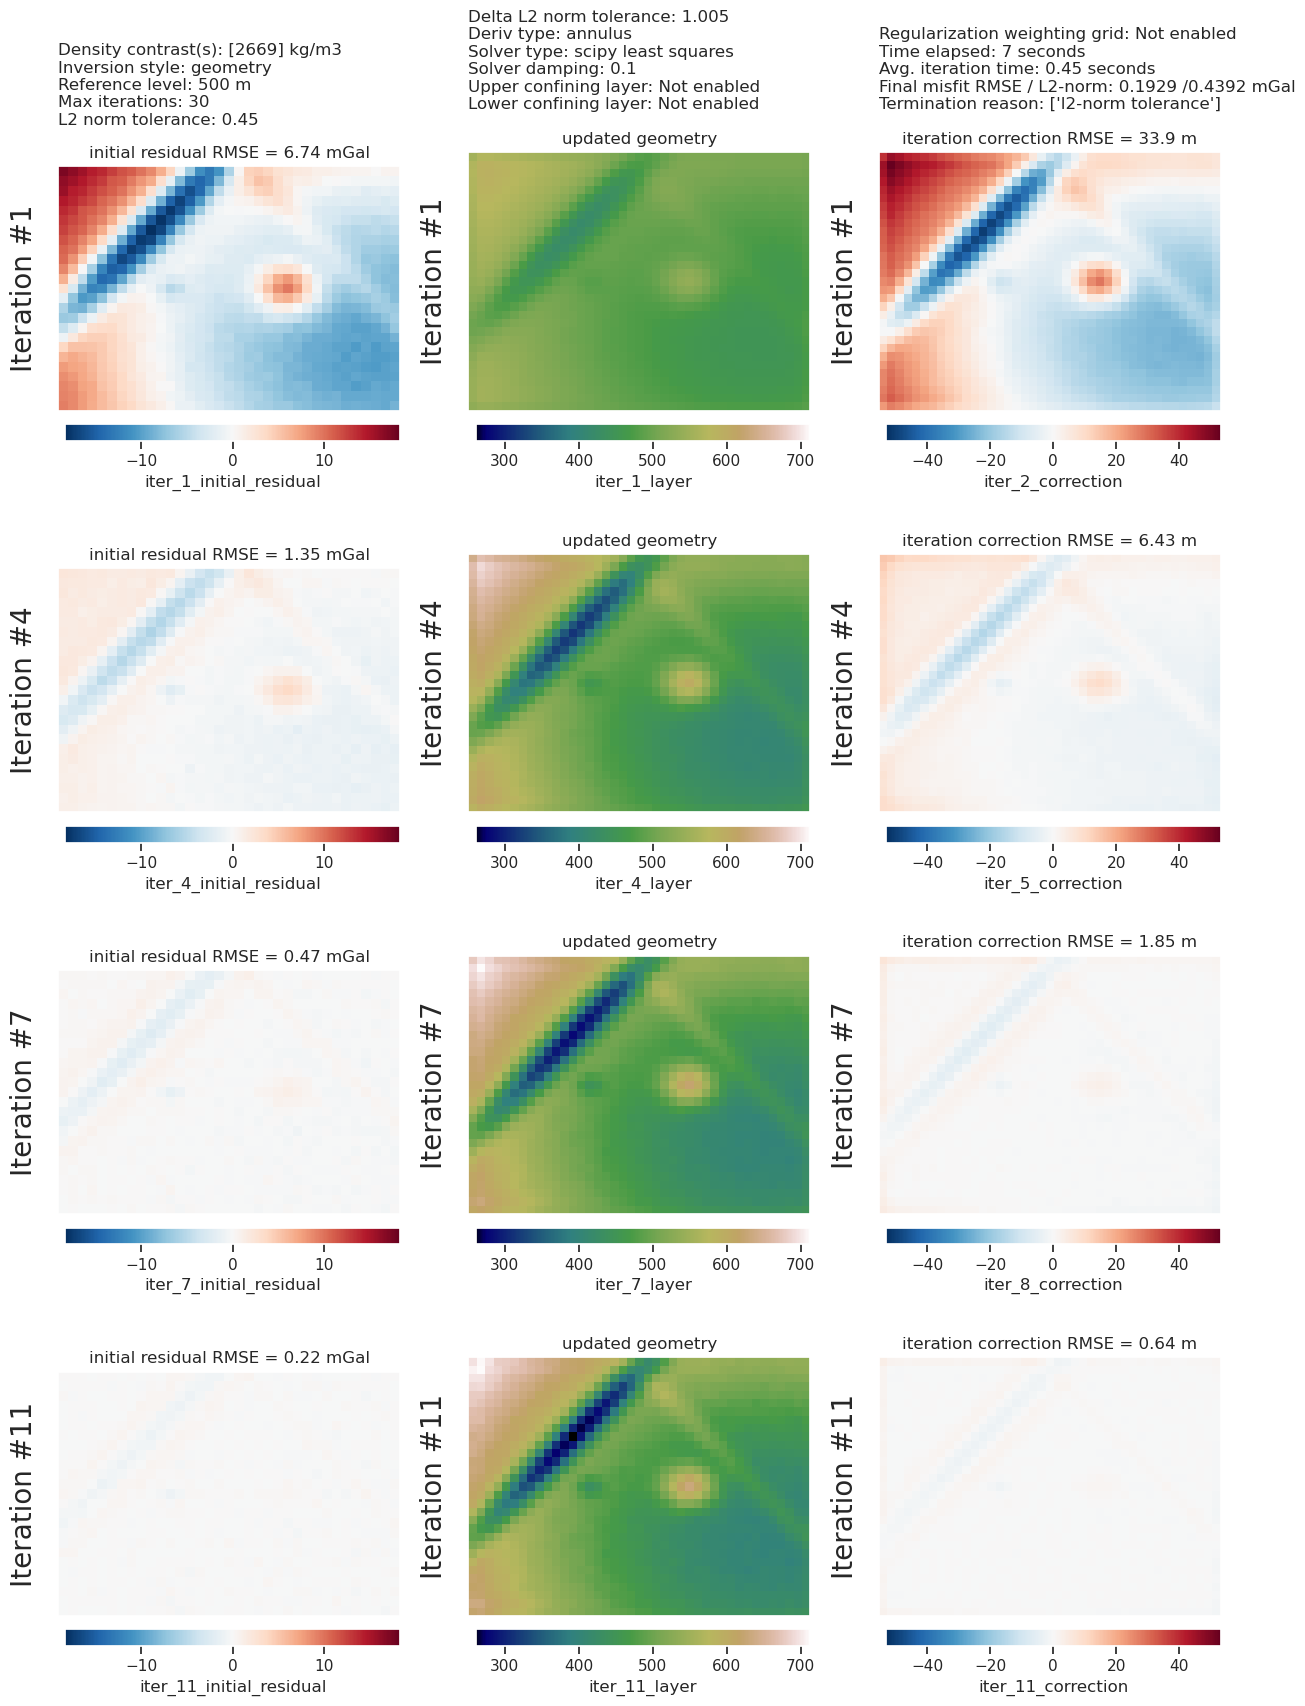

In [21]:
inv.plot_inversion_results(
    iters_to_plot=4,
)

Below we compare the true topography with the results of the inversion to see how it performed. In this example, we assumed we knew the correct density contrast value and zref, and added minimal noise to the observed gravity, so we expect the inversion to accurately recover the true topography.

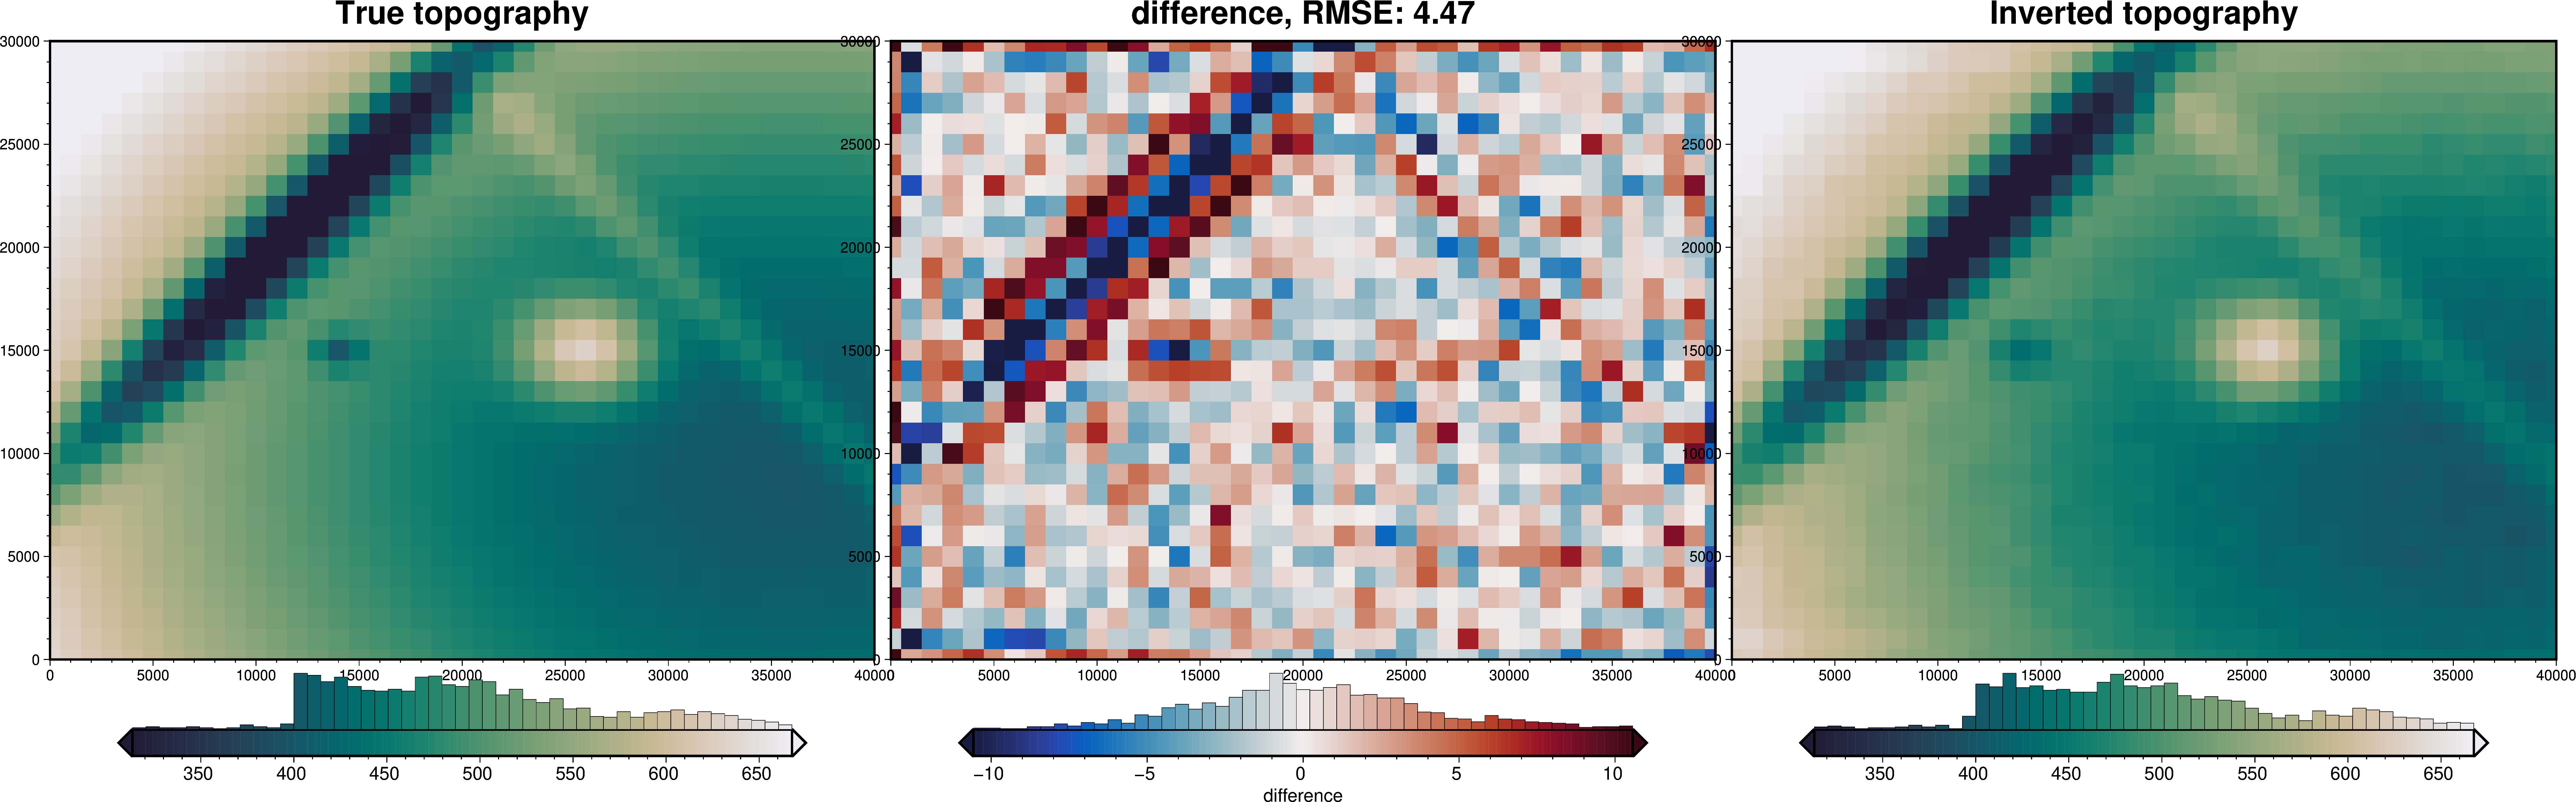

In [22]:
_ = ptk.grid_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    frame=True,
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered topography is low, but this is not too surprising since we gave the inversion the true density contrast and appropriate zref value.

See the [density optimization notebook](05_density_optimization.ipynb) and the [reference level optimization notebook](06_reference_level_optimization.ipynb) for examples of how to best choose those values in scenarios where you don't know them.

The [damping cross validation notebook](04_damping_cross_validation.ipynb) will explain how to use cross validation to choose the optimal damping parameter value. Here, we simply chose an arbitrary value which appeared to work well. With real data with noise, this choice of the damping parameter becomes very important. 